Importing Modules

In [1]:
import torch
import torchvision
import torch.nn as nn
import matplotlib
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
import os
import time
import numpy as np
import argparse
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.utils import save_image
matplotlib.style.use('ggplot')
import sys, importlib as impL
import pandas as pd
print("pandas: ", pd.__version__)
print("torch: ", torch.__version__)
print("numpy: ", np.__version__)

pandas:  1.1.0
torch:  1.6.0
numpy:  1.19.1


In [2]:
import socket
def get_var_by_comp_name(variableName):
    curCompName = socket.gethostname()
    retVal = None
    if variableName == 'khs_dir':
        if curCompName == 'doga-MSISSD':
            base_dir = '/mnt/USB_HDD_1TB/GitHub/keyhandshapediscovery'  # for bogazici kasa
        elif curCompName == 'WsUbuntu05' or curCompName == 'wsubuntu':
            base_dir = '/home/wsubuntu/GitHub/keyhandshapediscovery'  # for WS Doga DHO
        elif curCompName == 'doga-msi-ubu':
            base_dir = None  # for laptop
        retVal = base_dir
    if variableName == 'data_path':
        if curCompName == 'doga-MSISSD':
            base_dir = '/mnt/USB_HDD_1TB/Datasets'  # for bogazici kasa
        elif curCompName == 'WsUbuntu05' or curCompName == 'wsubuntu':
            base_dir = '/mnt/SSD_Data/DataPath'  # for WS Doga DHO
        elif curCompName == 'doga-msi-ubu':
            base_dir = None  # for laptop
        retVal = base_dir
    if variableName == 'experiment_path':
        if curCompName == 'doga-MSISSD':
            base_dir = '/mnt/USB_HDD_1TB/GitHub/keyhandshapediscovery/experiments/SPARSE_TORCH'  # for bogazici kasa
        elif curCompName == 'WsUbuntu05' or curCompName == 'wsubuntu':
            base_dir = '/mnt/SSD_Data/vaesae_experiments'  # for WS Doga DHO
        elif curCompName == 'doga-msi-ubu':
            base_dir = None  # for laptop
        retVal = base_dir
        
    print(curCompName + '_' + variableName, '=',  retVal)
    if retVal is None:
        os.error(5)
    return retVal

khs_dir = get_var_by_comp_name('khs_dir')
data_path = get_var_by_comp_name('data_path')
experiment_path = get_var_by_comp_name('experiment_path')

wsubuntu_khs_dir = /home/wsubuntu/GitHub/keyhandshapediscovery
wsubuntu_data_path = /mnt/SSD_Data/DataPath
wsubuntu_experiment_path = /mnt/SSD_Data/vaesae_experiments


In [3]:
sys.path.insert(1, khs_dir)
import helperFuncs as funcH

In [4]:
EXPERIMENT_ID = 27
LOSS_TYPE='cre'
LOSS_REDUCTION='mean' #'batchmean','sum'
SIGMOID_ACT=False
APPLY_LOG_SOFTMAX=False
MSE_PLUS_MINUS='+'
APPLY_SPARSITY_TO='bottleneck' #all

In [5]:
def calc_bottleneck_acc(bottleneck_vec, lab_vec):
    pred_vec = np.argmax(bottleneck_vec.T, axis=0).T.squeeze()
    centroid_info_pdf = funcH.get_cluster_centroids(bottleneck_vec, pred_vec, kluster_centers=None, verbose=0)
    _confMat_preds, kluster2Classes, kr_pdf, weightedPurity, cnmxh_perc = funcH.countPredictionsForConfusionMat(lab_vec, pred_vec, centroid_info_pdf=centroid_info_pdf, labelNames=None)
    sampleCount = np.sum(np.sum(_confMat_preds))
    acc = 100 * np.sum(np.diag(_confMat_preds)) / sampleCount
    bmx, bmn = np.max(bottleneck_vec), np.min(bottleneck_vec)
    return acc, bmx, bmn

funcH.setPandasDisplayOpts()

Constructing the Argument Parsers

In [6]:
#ap = argparse.ArgumentParser()
#ap.add_argument('-e', '--epochs', type=int, default=10, help='number of epochs to train our network for')
#ap.add_argument('-l', '--reg_param', type=float, default=0.001, help='regularization parameter `lambda`')
#ap.add_argument('-sc', '--add_sparse', type=str, default='yes', help='whether to add sparsity contraint or not')
#args = vars(ap.parse_args())
epochs = 100  # args['epochs']
reg_param = 0.001  # args['reg_param']
add_sparsity = 'yes'  # args['add_sparse']
learning_rate = 1e-4
batch_size = 32
print(f"Add sparsity regularization: {add_sparsity}")

Add sparsity regularization: yes


here I will change the data loader per my need

In [7]:
# get the computation device
def get_device():
    return 'cuda:0' if torch.cuda.is_available() else 'cpu'
device = get_device()
print(device)

cpu


In [8]:
# image transformations
transform = transforms.Compose([
    transforms.ToTensor(),
])

FOLDERS = {
    "data": data_path,
    "experiment": os.path.join(experiment_path, 'sparse_torch_ae_' + str(EXPERIMENT_ID).zfill(3)),
}
FOLDERS["model_save"] = os.path.join(FOLDERS["experiment"], "model")
FOLDERS["decoder_image_path_tr"] = os.path.join(FOLDERS["experiment"], "output_images_tr")
FOLDERS["decoder_image_path_va"] = os.path.join(FOLDERS["experiment"], "output_images_va")
funcH.createDirIfNotExist(FOLDERS["model_save"])
funcH.createDirIfNotExist(FOLDERS["decoder_image_path_tr"])
funcH.createDirIfNotExist(FOLDERS["decoder_image_path_va"])

trainset = datasets.FashionMNIST(
    root=FOLDERS["data"],
    train=True, 
    download=True,
    transform=transform
)
testset = datasets.FashionMNIST(
    root=FOLDERS["data"],
    train=False,
    download=True,
    transform=transform
)
 
# trainloader
trainloader = DataLoader(
    trainset, 
    batch_size=batch_size,
    shuffle=True
)
#testloader
testloader = DataLoader(
    testset, 
    batch_size=batch_size, 
    shuffle=False
)

In [9]:
# define the autoencoder model
class SparseAutoencoder(nn.Module):
    def __init__(self, loss_type):
        super(SparseAutoencoder, self).__init__()
 
        # encoder
        self.enc1 = nn.Linear(in_features=784, out_features=256)
        self.enc2 = nn.Linear(in_features=256, out_features=128)
        self.enc3 = nn.Linear(in_features=128, out_features=64)
        self.enc4 = nn.Linear(in_features=64, out_features=32)
        self.enc5 = nn.Linear(in_features=32, out_features=32)
 
        # decoder 
        self.dec1 = nn.Linear(in_features=32, out_features=32)
        self.dec2 = nn.Linear(in_features=32, out_features=64)
        self.dec3 = nn.Linear(in_features=64, out_features=128)
        self.dec4 = nn.Linear(in_features=128, out_features=256)
        self.dec5 = nn.Linear(in_features=256, out_features=784)
        
        self.loss_type=loss_type
        self.device = get_device()
        print("SparseAutoencoder - loss_type(" + loss_type +"), device(" + self.device + ")")

    def encode(self, x):
        # encoding
        x = F.relu(self.enc1(x))
        x = F.relu(self.enc2(x))
        x = F.relu(self.enc3(x))
        x = F.relu(self.enc4(x))
        #if self.loss_type=='cre':
        #    bottleneck = self.enc5(x) 
        #else:
        bottleneck = F.relu(self.enc5(x))  
        
        return bottleneck
        
    def decode(self, bottleneck):
        # decoding
        #if self.loss_type=='cre':
        #    x = F.relu(self.dec1(F.relu(bottleneck)))
        #else:
        x = F.relu(self.dec1(bottleneck))
        
        x = F.relu(self.dec2(x))
        x = F.relu(self.dec3(x))
        x = F.relu(self.dec4(x))
        x = F.relu(self.dec5(x)) 
        return x
        
    def forward(self, x):
        bottleneck = self.encode(x)
        x = self.decode(bottleneck)
        return x, bottleneck

model = SparseAutoencoder(loss_type=LOSS_TYPE).to(device)

SparseAutoencoder - loss_type(cre), device(cpu)


In [10]:
# the loss function
criterion = nn.MSELoss()
# the optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [11]:
# get the layers as a list
model_children = list(model.children())
[print(i) for i in model_children]

Linear(in_features=784, out_features=256, bias=True)
Linear(in_features=256, out_features=128, bias=True)
Linear(in_features=128, out_features=64, bias=True)
Linear(in_features=64, out_features=32, bias=True)
Linear(in_features=32, out_features=32, bias=True)
Linear(in_features=32, out_features=32, bias=True)
Linear(in_features=32, out_features=64, bias=True)
Linear(in_features=64, out_features=128, bias=True)
Linear(in_features=128, out_features=256, bias=True)
Linear(in_features=256, out_features=784, bias=True)


[None, None, None, None, None, None, None, None, None, None]

In [12]:
def loss_l1(bottleneck):
    return torch.mean(torch.abs(bottleneck))

def loss_l2(bottleneck):
    return torch.mean(torch.pow(bottleneck, torch.tensor(2.0).to(device))).sqrt()

def kl_divergence(bottleneck, reduction):
    bt = torch.sigmoid(bottleneck)  # sigmoid because we need the probability distributions
    rho_val = 1/bt.size(1)
    rho_mat = torch.tensor([rho_val] * np.ones(bt.size()), dtype=torch.float32).to(device)
    #https://discuss.pytorch.org/t/kl-divergence-produces-negative-values/16791/13
    #KLDLoss(p, q), sum(q) needs to equal one
    #p = log_softmax(tensor)
    loss_ret_1 = F.kl_div(F.log_softmax(bt, dim=1).to(device), rho_mat, reduction=reduction)
    # torch.sum(rho * torch.log(rho / bottleneck) + (1 - rho) * torch.log((1 - rho) / (1 - bottleneck)))
    return loss_ret_1


def loss_crossentropy(bottleneck, sigmoidAct, reduction, apply_log_softmax, print_info):
    loss_fun = torch.nn.CrossEntropyLoss(reduction=reduction)
    if sigmoidAct and apply_log_softmax:  
        if print_info:
            print("1-",sigmoidAct,apply_log_softmax)
        bt = torch.sigmoid(bottleneck)  # sigmoid because we need the probability distributions
        _, preds = torch.max(bt, 1)
        loss_ret_1 = loss_fun(F.log_softmax(bt, dim=1).to(device), preds)    
    elif sigmoidAct and not apply_log_softmax:     
        if print_info:
            print("2-",sigmoidAct,apply_log_softmax)
        bt = torch.sigmoid(bottleneck)  # sigmoid because we need the probability distributions
        _, preds = torch.max(bt, 1)
        loss_ret_1 = loss_fun(bt.to(device), preds)    
    elif not sigmoidAct and apply_log_softmax:
        if print_info:
            print("3-",sigmoidAct,apply_log_softmax)
        _, preds = torch.max(bottleneck, 1)
        loss_ret_1 = loss_fun(F.log_softmax(bottleneck, dim=1).to(device), preds)    
    else:#nothing
        if print_info:
            print("4-",sigmoidAct,apply_log_softmax)
        _, preds = torch.max(bottleneck, 1)
        loss_ret_1 = loss_fun(bottleneck.to(device), preds)
    return loss_ret_1

def loss_crossentropy_old(bottleneck, sigmoidAct, reduction, apply_log_softmax, print_info):
    loss_fun = torch.nn.CrossEntropyLoss(reduction=reduction)
    if sigmoidAct:
        bt = torch.sigmoid(bottleneck)  # sigmoid because we need the probability distributions
    else:
        bt = bottleneck    
    _, preds = torch.max(bt, 1)
    loss_ret_1 = loss_fun(F.log_softmax(bt, dim=1).to(device), preds)    
    return loss_ret_1

In [13]:
# define the sparse loss function
def sparse_loss(autoencoder, images, print_info, loss_type):
    loss = 0
    values = images
    for i in range(len(model_children)):
        values = F.relu((model_children[i](values)))
        #if print_info:
            #print(i, ' shape=', values.shape)
        if loss_type=='l1':
            loss += loss_l1(values)
        if loss_type=='l2':
            loss += loss_l2(values)
        if loss_type=='kl':
            loss += kl_divergence(values, reduction=LOSS_REDUCTION)
        if loss_type=='cre':
            loss += loss_crossentropy(values, sigmoidAct=SIGMOID_ACT, reduction=LOSS_REDUCTION, apply_log_softmax=APPLY_LOG_SOFTMAX, print_info=print_info)
        if print_info:
            print(loss_type,loss)
    return loss

def sparse_loss_bottleneck(bottleneck, print_info, loss_type):
    loss = 0
    #if print_info:
        #print(i, ' shape=', values.shape)
    if loss_type=='l1':
        loss += loss_l1(bottleneck)
    if loss_type=='l2':
        loss += loss_l2(bottleneck)
    if loss_type=='kl':
        loss += kl_divergence(bottleneck, reduction=LOSS_REDUCTION)
    if loss_type=='cre':
        loss += loss_crossentropy(bottleneck, sigmoidAct=SIGMOID_ACT, reduction=LOSS_REDUCTION, apply_log_softmax=APPLY_LOG_SOFTMAX, print_info=print_info)
    if print_info:
        print(loss_type,loss)
    return loss

In [14]:
def save_decoded_image(img, name):
    img = img.view(img.size(0), 1, 28, 28)
    save_image(img, name)

# define the training function
def fit(model, dataloader, epoch, print_losses_fit):
    print('TrEpoch({:03d}) - '.format(epoch), end='')
    model.train()
    running_loss = 0.0
    
    lab_vec = []
    bottleneck_vec = []
    sparsity_loss_sum = 0
    mse_sum = 0
       
    for data in dataloader:
        img, lb = data
        lab_vec.append(lb)
        
        img = img.to(device)
        img = img.view(img.size(0), -1)
        optimizer.zero_grad()
        outputs, bottleneck = model(img)
        bottleneck_vec.append(bottleneck)
        mse_loss = criterion(outputs, img)
        mse_sum += mse_loss.item()
        #if print_losses_fit:
            #print("mse_loss:", mse_loss.to('cpu'))
            #print("bottleneck:", bottleneck.to('cpu'))
        if add_sparsity == 'yes':
            if APPLY_SPARSITY_TO=='all':
                sp_loss = sparse_loss(model, img, print_losses_fit, model.loss_type)
            elif APPLY_SPARSITY_TO=='bottleneck': #all
                sp_loss = sparse_loss_bottleneck(bottleneck, print_losses_fit, model.loss_type)
            else:
                os.exit(4)
                
            sparsity_loss_sum += sp_loss.item()
            
            # add the sparsity penalty
            if print_losses_fit:
                print("sp_loss:", sparsity_loss_sum)
                
            if MSE_PLUS_MINUS=='-':
                loss = mse_loss - reg_param * sp_loss
            elif MSE_PLUS_MINUS=='+':
                loss = mse_loss + reg_param * sp_loss
        else:
            loss = mse_loss
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        print_losses_fit = False
    
    lab_vec = np.asarray(torch.cat(lab_vec).to(torch.device('cpu')))
    bottleneck_vec = np.asarray(torch.cat(bottleneck_vec).to(torch.device('cpu')).detach().numpy())
    acc, bmx, bmn = calc_bottleneck_acc(bottleneck_vec, lab_vec)
    #print("tr bottleneck accuracy=", acc, ", max=", bmx, ", min=", bmn, ", sparsity_loss_sum=", sparsity_loss_sum)
  
    result_df = pd.DataFrame(np.array([[acc, bmx, bmn, mse_sum, sparsity_loss_sum, running_loss]]), columns=['acc','bmx','bmn','mse','spr','run'])
    #print(df.iloc[0]['mse']) #'acc','bmx','bmn','mse','spr','run'
    print("\n",result_df)
    if epoch % 2 == 0:
        difn = os.path.join(FOLDERS["decoder_image_path_tr"], "train"+str(epoch).zfill(3)+".png")
        save_decoded_image(outputs.cpu().data, difn)
    return result_df

In [15]:
# define the validation function
def validate(model, dataloader, epoch, print_losses_fit):
    print('ValEpoch({:03d}) - '.format(epoch), end='')
    model.eval()
    running_loss = 0.0
    lab_vec = []
    bottleneck_vec = []
    with torch.no_grad():
        for data in dataloader:
            img, lb = data
            lab_vec.append(lb)
            img = img.to(device)
            img = img.view(img.size(0), -1)
            outputs, bottleneck = model(img)
            bottleneck_vec.append(bottleneck)
            loss = criterion(outputs, img)
            running_loss += loss.item()
    # save the reconstructed images every 5 epochs
    lab_vec = np.asarray(torch.cat(lab_vec).to(torch.device('cpu')))
    bottleneck_vec = np.asarray(torch.cat(bottleneck_vec).to(torch.device('cpu')).detach().numpy())
    acc, bmx, bmn = calc_bottleneck_acc(bottleneck_vec, lab_vec)

    result_df = pd.DataFrame(np.array([[acc, bmx, bmn, running_loss]]), columns=['acc','bmx','bmn','run'])
    print("\n",result_df)
    
    if epoch % 2 == 0:
        outputs = outputs.view(outputs.size(0), 1, 28, 28).cpu().data
        difn = os.path.join(FOLDERS["decoder_image_path_va"], "reconstruction"+str(epoch).zfill(3)+".png")
        save_image(outputs, difn)
    return result_df

In [16]:
# train and validate the autoencoder neural network
start = time.time()
print_losses_fit = True

train_loss = []
trn_spars_loss = []
trn_bot_acc = []
val_loss = []
val_bot_acc = []

result_df_tr_all = pd.DataFrame(columns=['acc','bmx','bmn','mse','spr','run'])
result_df_va_all = pd.DataFrame(columns=['acc','bmx','bmn','run'])

print("stae_ws :: ")
print("EXPERIMENT_ID: ", EXPERIMENT_ID)
print("LOSS_TYPE : ", LOSS_TYPE)
print("LOSS_REDUCTION : ", LOSS_REDUCTION)
print("SIGMOID_ACT : ", SIGMOID_ACT)
print("APPLY_LOG_SOFTMAX : ", APPLY_LOG_SOFTMAX)
print("APPLY_SPARSITY_TO : ", APPLY_SPARSITY_TO)
print("total loss = mse_loss " + MSE_PLUS_MINUS + " reg_param("+ str(reg_param) +") * sp_loss")

for epoch in range(epochs):
    print(f"*****\n Epoch {epoch} of {epochs}")
    result_df_tr = fit(model, trainloader, epoch, print_losses_fit)
    result_df_va = validate(model, testloader, epoch, print_losses_fit)
    print_losses_fit = epoch%5==0 and epoch>0
    result_df_tr_all = result_df_tr_all.append(result_df_tr, ignore_index=True)
    result_df_va_all = result_df_va_all.append(result_df_va, ignore_index=True)
    
end = time.time()
 
print(f"{(end-start)/60:.3} minutes")
# save the trained model

mofn = os.path.join(FOLDERS["model_save"], "sparse_ae_"+str(epoch).zfill(3)+".pth")
torch.save(model.state_dict(), mofn)

stae_ws :: 
EXPERIMENT_ID:  27
LOSS_TYPE :  cre
LOSS_REDUCTION :  mean
SIGMOID_ACT :  False
APPLY_LOG_SOFTMAX :  False
APPLY_SPARSITY_TO :  bottleneck
total loss = mse_loss + reg_param(0.001) * sp_loss
*****
 Epoch 0 of 100
TrEpoch(000) - 4- False False
cre tensor(3.2875, grad_fn=<AddBackward0>)
sp_loss: 3.287532329559326

     acc     bmx  bmn      mse      spr      run
0  10.0  77.021  0.0  150.708  334.568  151.043
ValEpoch(000) - 
     acc     bmx  bmn     run
0  10.0  75.509  0.0  18.407
*****
 Epoch 1 of 100
TrEpoch(001) - 
     acc     bmx  bmn      mse    spr      run
0  10.0  83.415  0.0  104.233  4.809  104.238
ValEpoch(001) - 
     acc     bmx  bmn     run
0  10.0  85.049  0.0  15.982
*****
 Epoch 2 of 100
TrEpoch(002) - 
     acc     bmx  bmn     mse   spr     run
0  10.0  91.695  0.0  84.834  2.91  84.836
ValEpoch(002) - 
     acc     bmx  bmn     run
0  10.0  87.592  0.0  13.367
*****
 Epoch 3 of 100
TrEpoch(003) - 
     acc     bmx  bmn    mse    spr     run
0  10.0  90.


     acc     bmx  bmn     mse    spr     run
0  10.0  77.801  0.0  41.554  1.323  41.555
ValEpoch(036) - 
     acc     bmx  bmn    run
0  10.0  74.552  0.0  6.989
*****
 Epoch 37 of 100
TrEpoch(037) - 
     acc     bmx  bmn     mse    spr     run
0  10.0  77.152  0.0  41.336  1.308  41.338
ValEpoch(037) - 
     acc     bmx  bmn    run
0  10.0  74.626  0.0  6.952
*****
 Epoch 38 of 100
TrEpoch(038) - 
     acc     bmx  bmn     mse    spr     run
0  10.0  77.347  0.0  40.844  1.268  40.845
ValEpoch(038) - 
     acc     bmx  bmn    run
0  10.0  73.655  0.0  6.787
*****
 Epoch 39 of 100
TrEpoch(039) - 
     acc     bmx  bmn     mse    spr     run
0  10.0  75.885  0.0  39.737  1.261  39.739
ValEpoch(039) - 
     acc     bmx  bmn    run
0  10.0  73.268  0.0  6.647
*****
 Epoch 40 of 100
TrEpoch(040) - 
     acc     bmx  bmn     mse    spr     run
0  10.0  75.437  0.0  39.364  1.249  39.366
ValEpoch(040) - 
     acc     bmx  bmn    run
0  10.0  72.848  0.0  6.624
*****
 Epoch 41 of 100
TrEpo

TrEpoch(074) - 
     acc     bmx  bmn     mse   spr     run
0  10.0  61.113  0.0  32.667  0.97  32.668
ValEpoch(074) - 
     acc     bmx  bmn    run
0  10.0  59.913  0.0  5.563
*****
 Epoch 75 of 100
TrEpoch(075) - 
     acc     bmx  bmn     mse    spr     run
0  10.0  60.982  0.0  32.612  0.983  32.613
ValEpoch(075) - 
     acc     bmx  bmn    run
0  10.0  59.965  0.0  5.538
*****
 Epoch 76 of 100
TrEpoch(076) - 4- False False
cre tensor(0.0017, grad_fn=<AddBackward0>)
sp_loss: 0.001714541343972087

     acc     bmx  bmn     mse    spr     run
0  10.0  60.664  0.0  32.525  0.976  32.526
ValEpoch(076) - 
     acc     bmx  bmn    run
0  10.0  59.309  0.0  5.528
*****
 Epoch 77 of 100
TrEpoch(077) - 
     acc     bmx  bmn     mse    spr     run
0  10.0  60.534  0.0  32.235  0.973  32.236
ValEpoch(077) - 
     acc     bmx  bmn    run
0  10.0  59.414  0.0  5.483
*****
 Epoch 78 of 100
TrEpoch(078) - 
     acc    bmx  bmn     mse    spr     run
0  10.0  59.99  0.0  32.125  0.973  32.126
Val

In [17]:
print(result_df_tr_all)

     acc     bmx  bmn      mse      spr      run
0   10.0  77.021  0.0  150.708  334.568  151.043
1   10.0  83.415  0.0  104.233    4.809  104.238
2   10.0  91.695  0.0   84.834    2.910   84.836
3   10.0  90.201  0.0   78.060    2.807   78.063
4   10.0  89.298  0.0   73.643    2.477   73.646
5   10.0  93.021  0.0   69.797    2.031   69.799
6   10.0  94.678  0.0   66.240    1.598   66.242
7   10.0  95.276  0.0   63.928    1.532   63.930
8   10.0  94.493  0.0   61.270    1.528   61.271
9   10.0  93.688  0.0   59.866    1.502   59.868
10  10.0  92.726  0.0   59.181    1.498   59.182
11  10.0  92.244  0.0   57.268    1.424   57.269
12  10.0  92.301  0.0   55.535    1.339   55.537
13  10.0  91.872  0.0   54.320    1.257   54.321
14  10.0  91.545  0.0   51.546    1.214   51.547
15  10.0  90.692  0.0   49.910    1.203   49.911
16  10.0  90.820  0.0   49.375    1.175   49.376
17  10.0  88.667  0.0   49.014    1.203   49.015
18  10.0  88.402  0.0   47.932    1.186   47.934
19  10.0  87.858  0.

In [18]:
print(result_df_va_all)

     acc     bmx  bmn     run
0   10.0  75.509  0.0  18.407
1   10.0  85.049  0.0  15.982
2   10.0  87.592  0.0  13.367
3   10.0  86.079  0.0  12.674
4   10.0  88.085  0.0  11.910
5   10.0  90.819  0.0  11.437
6   10.0  91.628  0.0  10.879
7   10.0  91.468  0.0  10.589
8   10.0  90.637  0.0  10.095
9   10.0  90.289  0.0   9.989
10  10.0  89.450  0.0   9.795
11  10.0  89.916  0.0   9.508
12  10.0  89.976  0.0   9.215
13  10.0  89.353  0.0   8.838
14  10.0  88.732  0.0   8.452
15  10.0  87.839  0.0   8.321
16  10.0  86.789  0.0   8.263
17  10.0  85.847  0.0   8.209
18  10.0  85.420  0.0   7.920
19  10.0  85.767  0.0   7.792
20  10.0  84.872  0.0   7.744
21  10.0  83.970  0.0   7.668
22  10.0  84.017  0.0   7.633
23  10.0  83.216  0.0   7.497
24  10.0  82.991  0.0   7.360
25  10.0  82.025  0.0   7.344
26  10.0  81.619  0.0   7.243
27  10.0  80.554  0.0   7.232
28  10.0  80.161  0.0   7.199
29  10.0  79.584  0.0   7.173
30  10.0  78.662  0.0   7.145
31  10.0  77.968  0.0   7.106
32  10.0  

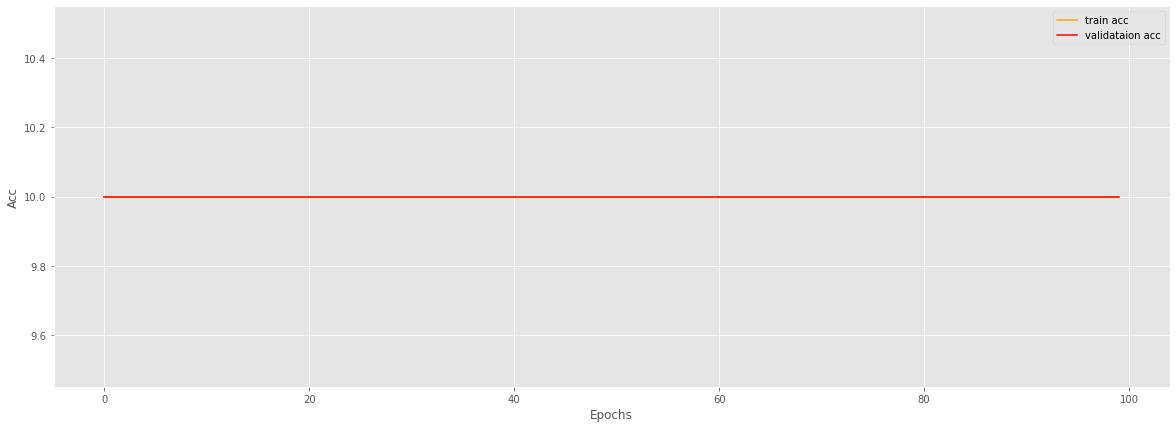

Max tr acc =  10.0
Max va acc =  10.0


In [19]:
tr_acc = result_df_tr_all.values[:,0].squeeze()
va_acc = result_df_va_all.values[:,0].squeeze()
plt.figure(figsize=(20, 7))
plt.plot(tr_acc, color='orange', label='train acc')
plt.plot(va_acc, color='red', label='validataion acc')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()
print("Max tr acc = ", np.max(tr_acc))
print("Max va acc = ", np.max(va_acc))

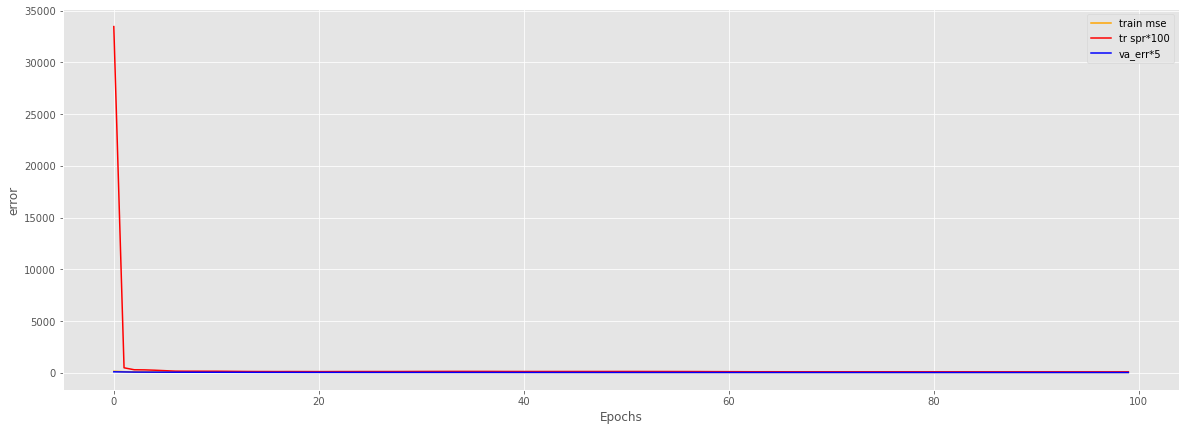

In [20]:
tr_mse = result_df_tr_all.values[:,3].squeeze()
tr_spr_50 = 100*result_df_tr_all.values[:,4].squeeze()
va_err = 5*result_df_va_all.values[:,-1].squeeze()
plt.figure(figsize=(20, 7))
plt.plot(tr_mse, color='orange', label='train mse')
plt.plot(tr_spr_50, color='red', label='tr spr*100')
plt.plot(va_err, color='blue', label='va_err*5')
plt.xlabel('Epochs')
plt.ylabel('error')
plt.legend()
plt.show()